# Workshop 3
Hi and welcome to the third workshop. This session will focus on boundary conditions, specifically list type boundary conditions. Some boundary conditions also allow for specifying arrays but we will cover that in the next session along with other array style input packages. You will also be introduced to use and configuration of time series files plus use and configuration of observation files. Additionally, we will introduce specifying auxiliary variables as either multipliers or for transport modelling.  

As before please make sure you have the MF6io.pdf document open while working through this notebook because it will show you the model input file structure for the specific boundary/package that you are creating and provides a more complete reference of the different options availabl.
.

# Imports first

In [1]:
import os
import sys
import shutil
import platform
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

print(f"Pandas version = {pd.__version__}")
print(f"Numpy version = {np.__version__}")
print(f"Flopy version = {flopy.__version__}")
print(f"Matplotlib version = {matplotlib.__version__}")

Pandas version = 2.0.3
Numpy version = 1.25.2
Flopy version = 3.4.1
Matplotlib version = 3.7.2


# Build a simple steady-state structured model

In [2]:
# Setup some folders
ws3 = os.path.join('workshop_3') # here we are making a path not creating the folder
gis_f = os.path.join(ws3,'GIS') # creating a sub-directory path for our gis input/output
model_f = os.path.join(ws3,'model') # creating a sub-directory path for our model input/output
plots_f = os.path.join(ws3,'plots') # creating a sub-directory path for our plots
for path in [ws3,gis_f,model_f,plots_f]:
    if os.path.exists(path): # here we are asking if the path exists on the computer. 
        shutil.rmtree(path)# if it does exist, delete it and all the files in it
        os.mkdir(path) # then remake it
    else:
        os.mkdir(path) # if it doesn't exist then make the folder

#Build some basic model objects
simulation_name = 'MySim' # setting a name for our simulation
sim = flopy.mf6.MFSimulation(sim_name=simulation_name, sim_ws=model_f, exe_name='mf6') # for a no frills mfsim.nam file
tdis = flopy.mf6.ModflowTdis(sim) # for the MySim.tdis file, recall this sets a single steady-state stress period
ims = flopy.mf6.ModflowIms(sim) # for the MySim.ims file, recall this sets up IMS as 'SIMPLE'
model_name = 'flow' # setting a name for our model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True) # for the flow.nam file

# Recall that there are default values applied to whatever you don't specify. 
# What esle should have been specified? Check your mf6io.pdf document.
# Make sure you are aware of the default entries that Flopy uses when you don't specify something for a package.
# REMEBER
# *** as the modeller it is your responsibility to check your input files ***
nrow = 20
ncol = 20
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=nrow, ncol=ncol) # why not just specify the values in here directly? Why use ncol=ncol?

# Taking a look at things

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delc array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delr array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:318: UserWarning: Failed to get data for idomain array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


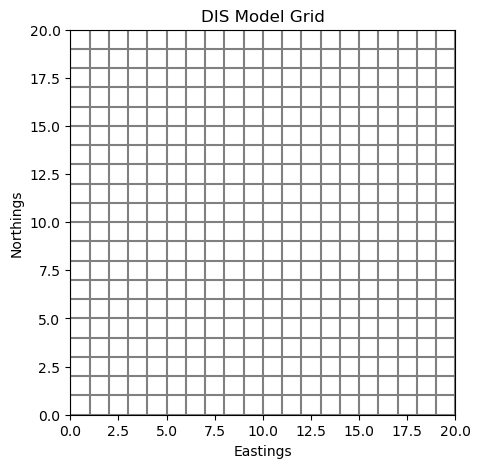

In [3]:
# Lets get a modelgrid object and have a look at the grid
mg = gwf.modelgrid

# create a figure to save to our plots folder
fig,ax = plt.subplots(figsize=(5,5)) # we are creating a figure object here so that we can dictate size
mg.plot(ax=ax)
ax.ticklabel_format(style='plain') # test what happens if you don't use this switch
ax.set_title('DIS Model Grid')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
# lets save it to our plots folder
figname = os.path.join(plots_f,'DIS_model_grid.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'DIS_model_grid.pdf')
fig.savefig(figname,dpi=300) 

# While we are here we can export it as a shapefile too.
dis.export(os.path.join(gis_f,'dis.shp'))
# ignore the warnings

# The stress period data dictionary
This is arguably the most important part of setting up boundary conditions. Once you grasp how to use and build the information needed in the stress period dictionary, the setup of a basic boundary conditions becomes reasonably straight forward. Whatever variables you see in the MF6io.pdf document between BEGIN PERIOD X and END PERIOD X will have to included in the dictionary. A dictionary is not always necessary as will be demonstrated but learning how to use them will be of benefit when it comes to setting up more complex versions of the same boundary. Boundary conditions are specific to a model so the model object must exist and be provided. Check the options block of whatever boundary condition you want to setup in the MF6io.pdf. Most of the settings in the options block are set with simple entries like option = "True", option= None, option = string, option = list_of_strings or option = integer etc. Check the Flopy defaults for each option and make sure you understand what it means to turn different settings on or off.

# Active or Inactive
You need to pay special attention to how the specific boundary you are configuring is made active or inactive. This varies for some boundaries and is noted in the MF6io.pdf document, so please be sure to read the specifics for the boundary you are working on. For the boundaries we will demonstrate in this workshop they are active from the first stress period you designate and will remain active until explicitly deactivated in a subsequent stress period. If you don't designate a stress period in which a boundary condition should first activate then Flopy assumes you want the boundary active throughout the entire simulation. You should always check your package input file before running your model anyway to ensure that everything is correct.

# Assign a constant head
To begin with we will assign a first type boundary because it is relatively simple and then we will demonstrate all the different boundary condition features offered in MF6.

In [4]:
# Assigning a constant head bounadry to specific model cells to be active all the time.

chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 10.],
                                                       [(0, 19, 19), 8.]])

# which model cells were assigned? what value were they given?
# recall we have a structured model so what do the numbers in the tuples represent?
# If this were a DISV grid, how would this input change?
# What if it was DISU?

# Writing your boundary condition package
If you want to be able to write your input file on its own then you need to name the object. What I am referring to here is the "chd = " part. You can instantiate the object without doing this and it will still work. We have been assigning names to the objects all along because it allows us to easily access the built in methods for that object. You've seen how we write a simulation before in Workshop 1. Writing the simulation will write all the model files you've created so far but here we only want the CHD package file we just created.

In [5]:
chd.write()
# note that it will determine what value needs to be assigned to the maxbound variable 
# based on the information you provide in your stress_period_data.

# Look for the file in your model folder and open it using your referred text editor or use the box below

INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data


In [6]:
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,f"{model_name}.chd"))]
# note the name of the input file will be the model name followed by the package Ftype acronym. 

# File generated by Flopy version 3.4.1 on 10/09/2023 at 12:23:44.
BEGIN options
END options

BEGIN dimensions
  MAXBOUND  2
END dimensions

BEGIN period  1
  1 1 1      10.00000000
  1 20 20       8.00000000
END period  1



# Plotting the boundary to check it
It is always a good idea to visually check that the cells you intended to set the boundary on are correct. You can do this by plotting the model grid and also plotting a specific boundary condition.

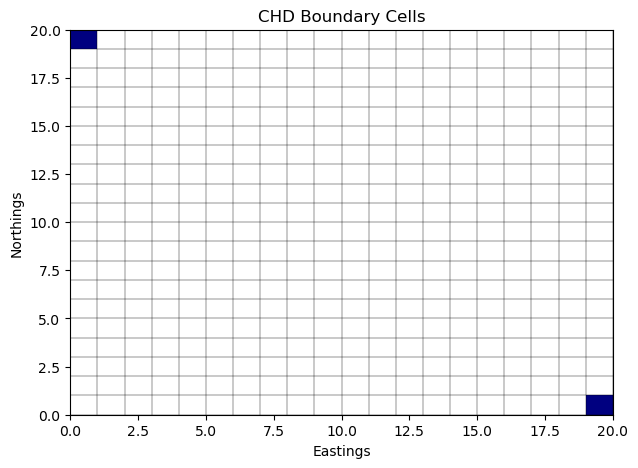

In [7]:
# Use the same method we applied previously in Workshop 2 to plot the modelgrid using a MapView object
# remeber the sequence of steps
# 1. Get modelgrid
# 2. Create figure instance
# 3. Create Mapview object
# 4. Tell the Mapview object what you want to plot
# 5. Modify your figure and axes to your preferred settings
# Note the line used to plot the bounadry condition

# Lets get a modelgrid object and have a look at the grid
mg = gwf.modelgrid

# create a figure instance to save to our plots folder
fig,ax = plt.subplots(figsize=(7,5)) # we are creating a figure object here so that we can dictate size note there are mutiple ways to do this

# Create the mapview object of the modelgrid and tell it to use the axes we created with our figure
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax) # note by not specifying a layer here it will assume layer 1

# say that you want the Mapview object to plot the grid with linewidth = 0.3 and colour the lines black
pmv.plot_grid(ax=ax, lw=0.3, color="black")

# Now I also want to plot the boundary condition so I specify the package object to plot
pmv.plot_bc(package=chd)


ax.set_title('CHD Boundary Cells')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
# lets save it to our plots folder
figname = os.path.join(plots_f,'CHD_bounadry_cells.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'CHD_bounadry_cells.pdf')
fig.savefig(figname,dpi=300) 

There are other options available when plotting a boundary condition that we will explore later. This includes specifying the layer you wish to view if you have a multi-layer model, specifying a stress period if you have boundary conditions that vary between active and inactive during your simulation, changing the colour of the plotted boundary and if you want to plot all boundaries.

# Selecting cells for a boundary condition
The first example demonstrates how to select individual cells in a structured grid but we may also want to assign a boundary condition along the edge of a model grid. Selecting model cells to assign a boundary condition to is half the battle so having different methods for selecting cells is going o help you a lot. We'll stick with our structured grid for now and look at selecting cells using some list comprehensions. We are going to assign our boundaries down the left and right side of our model as opposed to the corners. This means we need to build our stress period dictionary a little bit differently


In [8]:
# lets first get rid of our existing chd object
del chd 

# We only have one layer so if using l,r,c it means that we always have l=1 (or 0 for zero based)
l=0
# If we are on the left boundary then c is always 1 (or 0 for zero based) 
c = 0
# this means that the only variable we need to loop over is r
left_bound_nodes = [(l,r,c) for r in range(nrow)]
# lets take a look at it
left_bound_nodes

[(0, 0, 0),
 (0, 1, 0),
 (0, 2, 0),
 (0, 3, 0),
 (0, 4, 0),
 (0, 5, 0),
 (0, 6, 0),
 (0, 7, 0),
 (0, 8, 0),
 (0, 9, 0),
 (0, 10, 0),
 (0, 11, 0),
 (0, 12, 0),
 (0, 13, 0),
 (0, 14, 0),
 (0, 15, 0),
 (0, 16, 0),
 (0, 17, 0),
 (0, 18, 0),
 (0, 19, 0)]

So that sorts out the nodes but the stress period dictionary needs more information than that. We also need to specify the value of the constant head in those cells. Each entry in the period block of the input file needs to provided to Flopy as a list with the node id first then the rest of the boundary information, which is the constant head value in this case.

In [9]:
# Now we just add on the rest of the information that we want to include in the list comprehension and make each loop provide a list.
left_bound_stress_period_block = [[(l,r,c),10.] for r in range(nrow)]
left_bound_stress_period_block
# note what you produced is a list of lists evidenced by the leading and trailing double brackets

[[(0, 0, 0), 10.0],
 [(0, 1, 0), 10.0],
 [(0, 2, 0), 10.0],
 [(0, 3, 0), 10.0],
 [(0, 4, 0), 10.0],
 [(0, 5, 0), 10.0],
 [(0, 6, 0), 10.0],
 [(0, 7, 0), 10.0],
 [(0, 8, 0), 10.0],
 [(0, 9, 0), 10.0],
 [(0, 10, 0), 10.0],
 [(0, 11, 0), 10.0],
 [(0, 12, 0), 10.0],
 [(0, 13, 0), 10.0],
 [(0, 14, 0), 10.0],
 [(0, 15, 0), 10.0],
 [(0, 16, 0), 10.0],
 [(0, 17, 0), 10.0],
 [(0, 18, 0), 10.0],
 [(0, 19, 0), 10.0]]

In [10]:
# but we also need it for the right boundary so lets do the same thing here
# c on the right boundary is the number of columns minus one for zero base
c = ncol-1
right_bound_stress_period_block = [[(l,r,c),8.] for r in range(nrow)]
right_bound_stress_period_block

[[(0, 0, 19), 8.0],
 [(0, 1, 19), 8.0],
 [(0, 2, 19), 8.0],
 [(0, 3, 19), 8.0],
 [(0, 4, 19), 8.0],
 [(0, 5, 19), 8.0],
 [(0, 6, 19), 8.0],
 [(0, 7, 19), 8.0],
 [(0, 8, 19), 8.0],
 [(0, 9, 19), 8.0],
 [(0, 10, 19), 8.0],
 [(0, 11, 19), 8.0],
 [(0, 12, 19), 8.0],
 [(0, 13, 19), 8.0],
 [(0, 14, 19), 8.0],
 [(0, 15, 19), 8.0],
 [(0, 16, 19), 8.0],
 [(0, 17, 19), 8.0],
 [(0, 18, 19), 8.0],
 [(0, 19, 19), 8.0]]

In [11]:
# We need our left and right boundaries incorporated into a single list for the stress period dictionary so lets unpack them
chd_period_list = [*right_bound_stress_period_block,*left_bound_stress_period_block]
chd_period_list

[[(0, 0, 19), 8.0],
 [(0, 1, 19), 8.0],
 [(0, 2, 19), 8.0],
 [(0, 3, 19), 8.0],
 [(0, 4, 19), 8.0],
 [(0, 5, 19), 8.0],
 [(0, 6, 19), 8.0],
 [(0, 7, 19), 8.0],
 [(0, 8, 19), 8.0],
 [(0, 9, 19), 8.0],
 [(0, 10, 19), 8.0],
 [(0, 11, 19), 8.0],
 [(0, 12, 19), 8.0],
 [(0, 13, 19), 8.0],
 [(0, 14, 19), 8.0],
 [(0, 15, 19), 8.0],
 [(0, 16, 19), 8.0],
 [(0, 17, 19), 8.0],
 [(0, 18, 19), 8.0],
 [(0, 19, 19), 8.0],
 [(0, 0, 0), 10.0],
 [(0, 1, 0), 10.0],
 [(0, 2, 0), 10.0],
 [(0, 3, 0), 10.0],
 [(0, 4, 0), 10.0],
 [(0, 5, 0), 10.0],
 [(0, 6, 0), 10.0],
 [(0, 7, 0), 10.0],
 [(0, 8, 0), 10.0],
 [(0, 9, 0), 10.0],
 [(0, 10, 0), 10.0],
 [(0, 11, 0), 10.0],
 [(0, 12, 0), 10.0],
 [(0, 13, 0), 10.0],
 [(0, 14, 0), 10.0],
 [(0, 15, 0), 10.0],
 [(0, 16, 0), 10.0],
 [(0, 17, 0), 10.0],
 [(0, 18, 0), 10.0],
 [(0, 19, 0), 10.0]]

In [12]:
# Now we can build our new CHD bounadry but this time we provide our list as an object name
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_period_list)
# write it
chd.write()
# Look at the file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,f"{model_name}.chd"))]

INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 40 based on size of stress_period_data
# File generated by Flopy version 3.4.1 on 10/09/2023 at 12:23:44.
BEGIN options
END options

BEGIN dimensions
  MAXBOUND  2
END dimensions

BEGIN period  1
  1 1 1      10.00000000
  1 20 20       8.00000000
END period  1



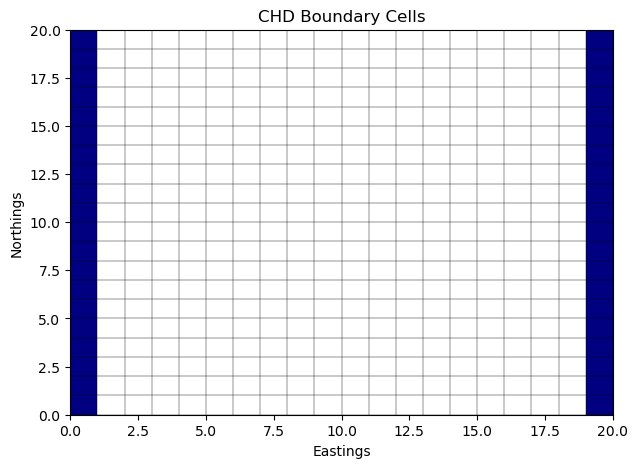

In [13]:
# Then plot it to have a better look

# Lets get a modelgrid object and have a look at the grid
mg = gwf.modelgrid

# create a figure instance to save to our plots folder
fig,ax = plt.subplots(figsize=(7,5)) # we are creating a figure object here so that we can dictate size note there are mutiple ways to do this

# Create the mapview object of the modelgrid and tell it to use the axes we created with our figure
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax) # note by not specifying a layer here it will assume layer 1

# say that you want the Mapview object to plot the grid with linewidth = 0.3 and colour the lines black
pmv.plot_grid(ax=ax, lw=0.3, color="black")

# Now I also want to plot the boundary condition so I specify the package object to plot
pmv.plot_bc(package=chd)


ax.set_title('CHD Boundary Cells')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
# lets save it to our plots folder
figname = os.path.join(plots_f,'CHD_bounadry_cells_LR.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'CHD_bounadry_cells_LR.pdf')
fig.savefig(figname,dpi=300) 

# But wait there is a problem here
Take a look at the model object. There are two boundary packages assigned to the model object even though we deleted the first chd object and used the same object name. MF6 allows multiples of the same boundary type to be used. Previous versions of model only allowed one instance of each boundary package. Look at the default naming convention used by Flopy when you have multiple instances of the same package. You can overrule this through the options block, which we will do shortly but first we need to fix our extra chd package option.


In [14]:
gwf

name = flow
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow


###################
Package chd_0
###################

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow


###################
Package chd_1
###################

package_name = chd_1
filename = flow_0.chd
package_type = chd
model_or_simulation_package = model
model_name = flow



In [15]:
print(gwf.get_package_list())
gwf.remove_package("CHD_0")
print(gwf.get_package_list())
# but which one did we keep?

['DIS', 'CHD_0', 'CHD_1']
['DIS', 'CHD_1']


But which one did we keep? Check by plotting to be sure.

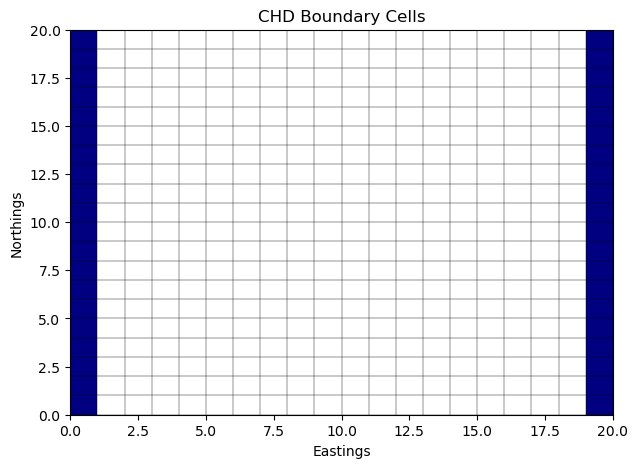

In [16]:
# Lets get a modelgrid object and have a look at the grid
mg = gwf.modelgrid

# create a figure instance to save to our plots folder
fig,ax = plt.subplots(figsize=(7,5)) # we are creating a figure object here so that we can dictate size note there are mutiple ways to do this

# Create the mapview object of the modelgrid and tell it to use the axes we created with our figure
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax) # note by not specifying a layer here it will assume layer 1

# say that you want the Mapview object to plot the grid with linewidth = 0.3 and colour the lines black
pmv.plot_grid(ax=ax, lw=0.3, color="black")

# Now I also want to plot the boundary condition so I specify the package object to plot
pmv.plot_bc(package=chd)


ax.set_title('CHD Boundary Cells')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
# lets save it to our plots folder
figname = os.path.join(plots_f,'CHD_bounadry_cells_LR.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'CHD_bounadry_cells_LR.pdf')
fig.savefig(figname,dpi=300) 

Lets delete the old input files and re-write our package

In [17]:
_ = [os.remove(os.path.join(model_f,x)) for x in os.listdir(model_f)]
# for x in os.listdir(model_f) means give me all the names of the files in the model folder
# os.remove(os.path.join(model_f,x)) means remove the file at the path given by os.path.join(model_f,x) 

print(os.listdir(model_f)) # should be an empty list

[]


In [18]:
# now write our model file
chd.write()

# but which file name will it use now?
print(os.listdir(model_f))

['flow_0.chd']


In [19]:
# Look at the file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,'flow_0.chd'))]

# File generated by Flopy version 3.4.1 on 10/09/2023 at 12:32:27.
BEGIN options
END options

BEGIN dimensions
  MAXBOUND  40
END dimensions

BEGIN period  1
  1 1 20       8.00000000
  1 2 20       8.00000000
  1 3 20       8.00000000
  1 4 20       8.00000000
  1 5 20       8.00000000
  1 6 20       8.00000000
  1 7 20       8.00000000
  1 8 20       8.00000000
  1 9 20       8.00000000
  1 10 20       8.00000000
  1 11 20       8.00000000
  1 12 20       8.00000000
  1 13 20       8.00000000
  1 14 20       8.00000000
  1 15 20       8.00000000
  1 16 20       8.00000000
  1 17 20       8.00000000
  1 18 20       8.00000000
  1 19 20       8.00000000
  1 20 20       8.00000000
  1 1 1      10.00000000
  1 2 1      10.00000000
  1 3 1      10.00000000
  1 4 1      10.00000000
  1 5 1      10.00000000
  1 6 1      10.00000000
  1 7 1      10.00000000
  1 8 1      10.00000000
  1 9 1      10.00000000
  1 10 1      10.00000000
  1 11 1      10.00000000
  1 12 1      10.00000000
  1 13 1

# Run a model
The following import will provide a function for you to use so that you can run a model using what you have setup so far. This is similar to the introductory model on the Flopy GitHub site. It will also do some post processing for you so that we can view results quickly and focus on the boundary conditions.


In [20]:
from helpers import ws3_mod1

In [21]:
# Clear out all existing modle files
_ = [os.remove(os.path.join(model_f,x)) for x in os.listdir(model_f)]

building ic package
building npf package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_1...
    writing package ic...
    writing package npf...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to ri

C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.

()

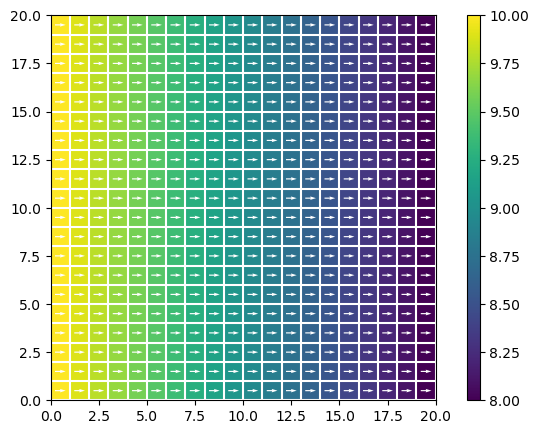

In [22]:
# run the function by passing in your sim and gwf objects
ws3_mod1(sim,gwf)

Let's try adding a well rouglhy at the centre of our model that extracts 1L/s (864 m3/d)

In [23]:
# Take a look at the MF6io.pdf document to see what is needed in the well stress period data block
# then follow the same procedure we did previously
wel1 = [(0,9,9), -10.0]
wel_period_list = [wel1] # remember that the stress_period data is a list of lists
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_period_list)

In [24]:
# check our model object to make sure the well package is there
gwf

name = flow
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow


###################
Package chd_1
###################

package_name = chd_1
filename = flow_0.chd
package_type = chd
model_or_simulation_package = model
model_name = flow


###################
Package ic
###################

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow


###################
Package npf
###################

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow


###################
Package oc
###################

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow


###################
Package wel_0
###################

package_name = wel_0
filename = flow.wel
pa

In [25]:
# Clear out all existing modle files
_ = [os.remove(os.path.join(model_f,x)) for x in os.listdir(model_f)]

building ic package
building npf package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_1...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package ic...
    writing package npf...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_0000

C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.

()

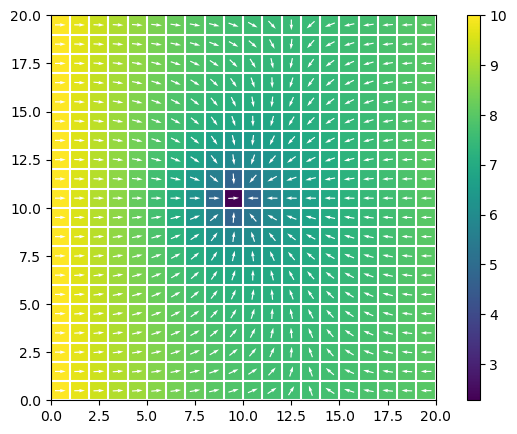

In [26]:
# Run our model again
ws3_mod1(sim,gwf)

# What if I want to know the fluxes associated with the boundaries?
You can get this from the list file but this workshop is on boundary conditions so we'll get straight from there. First, we will have to assign our boundaries some names and then setup an observation package to go with each of them. Now we will start to use some of the options in the options block. Again take a look at the MF6io.pdf document to check what you can do with each boundary condition. We will start by removing our CHD and WEL packages.


In [27]:
print(gwf.get_package_list())
gwf.remove_package("CHD") 
gwf.remove_package("WEL")
print(gwf.get_package_list())

['DIS', 'CHD_1', 'WEL_0', 'IC', 'NPF', 'OC']
['DIS', 'IC', 'NPF', 'OC']


# Why don't I have to remove the other packages as well?
The remaining packages will be overwritten because you can only have one of them assigned to a model. You can have several boundary conditions of the same type in each model so you need to delete the ones that you don't want or you may accidentally double up. Again it is your responsibility to check your input files before running your model.


# Adding boundary names

In [28]:
# now our stress period data list will have to include some more information so we need to rebuild it
c = 0
# this is what we had before [[(l,r,c),10.]
left_bound_stress_period_block = [[(l,r,c),10.0,"left_chd"] for r in range(nrow)] # All we did was add in a string for this bounadry name
# now the right one
c = ncol-1
right_bound_stress_period_block = [[(l,r,c),8.0,"right_chd"] for r in range(nrow)]
chd_period_list = [*left_bound_stress_period_block,*right_bound_stress_period_block]
chd_period_list

[[(0, 0, 0), 10.0, 'left_chd'],
 [(0, 1, 0), 10.0, 'left_chd'],
 [(0, 2, 0), 10.0, 'left_chd'],
 [(0, 3, 0), 10.0, 'left_chd'],
 [(0, 4, 0), 10.0, 'left_chd'],
 [(0, 5, 0), 10.0, 'left_chd'],
 [(0, 6, 0), 10.0, 'left_chd'],
 [(0, 7, 0), 10.0, 'left_chd'],
 [(0, 8, 0), 10.0, 'left_chd'],
 [(0, 9, 0), 10.0, 'left_chd'],
 [(0, 10, 0), 10.0, 'left_chd'],
 [(0, 11, 0), 10.0, 'left_chd'],
 [(0, 12, 0), 10.0, 'left_chd'],
 [(0, 13, 0), 10.0, 'left_chd'],
 [(0, 14, 0), 10.0, 'left_chd'],
 [(0, 15, 0), 10.0, 'left_chd'],
 [(0, 16, 0), 10.0, 'left_chd'],
 [(0, 17, 0), 10.0, 'left_chd'],
 [(0, 18, 0), 10.0, 'left_chd'],
 [(0, 19, 0), 10.0, 'left_chd'],
 [(0, 0, 19), 8.0, 'right_chd'],
 [(0, 1, 19), 8.0, 'right_chd'],
 [(0, 2, 19), 8.0, 'right_chd'],
 [(0, 3, 19), 8.0, 'right_chd'],
 [(0, 4, 19), 8.0, 'right_chd'],
 [(0, 5, 19), 8.0, 'right_chd'],
 [(0, 6, 19), 8.0, 'right_chd'],
 [(0, 7, 19), 8.0, 'right_chd'],
 [(0, 8, 19), 8.0, 'right_chd'],
 [(0, 9, 19), 8.0, 'right_chd'],
 [(0, 10, 19), 8.0, 

# Setting up a boundary observation package

In [29]:
# build obs data dictionary
chd_obs = {
    "chd_flux.csv": [                    # This is the user specified name of the file that the boundary fluxes will be stored in after the model has run
        ("Flux_left", "CHD", "left_chd"), # A tuple with what will be the column heading in the output csv file, the code for the type of observation , then the boundary name
        ("Flux_right", "CHD", "right_chd"), # A tuple with what will be the column heading in the output csv file, the code for the type of observation , then the boundary name
    ],
}
# So what you have is a dictionary with the output filename as the key
# note how the boundary name is used to efectivley group a bunch of boundary cells together
# We could have broken the boundary up into more sections with more names if wanted
# The code informing the observation package what it needs to observe differs for each package
# We will look through these in the workshop
chd_obs

{'chd_flux.csv': [('Flux_left', 'CHD', 'left_chd'),
  ('Flux_right', 'CHD', 'right_chd')]}

In [30]:
# Clear out all existing modle files
_ = [os.remove(os.path.join(model_f,x)) for x in os.listdir(model_f)]

In [31]:
chd = flopy.mf6.ModflowGwfchd(gwf, 
                              boundnames=True, # Tell it we will be using boundary names
                              observations=chd_obs, # Tell it we will be using an observation package
                              stress_period_data=chd_period_list)
# write the boundary and its observation package
chd.write()
chd.obs.write()

INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 40 based on size of stress_period_data


In [32]:
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,'flow.chd'))]
# Note the options have been added in

# File generated by Flopy version 3.4.1 on 10/09/2023 at 12:46:29.
BEGIN options
  BOUNDNAMES
  OBS6  FILEIN  flow.chd.obs
END options

BEGIN dimensions
  MAXBOUND  40
END dimensions

BEGIN period  1
  1 1 1      10.00000000  left_chd
  1 2 1      10.00000000  left_chd
  1 3 1      10.00000000  left_chd
  1 4 1      10.00000000  left_chd
  1 5 1      10.00000000  left_chd
  1 6 1      10.00000000  left_chd
  1 7 1      10.00000000  left_chd
  1 8 1      10.00000000  left_chd
  1 9 1      10.00000000  left_chd
  1 10 1      10.00000000  left_chd
  1 11 1      10.00000000  left_chd
  1 12 1      10.00000000  left_chd
  1 13 1      10.00000000  left_chd
  1 14 1      10.00000000  left_chd
  1 15 1      10.00000000  left_chd
  1 16 1      10.00000000  left_chd
  1 17 1      10.00000000  left_chd
  1 18 1      10.00000000  left_chd
  1 19 1      10.00000000  left_chd
  1 20 1      10.00000000  left_chd
  1 1 20       8.00000000  right_chd
  1 2 20       8.00000000  right_chd
  1 3 20       

In [33]:
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,'flow.chd.obs'))]
# this is what the observation file looks like
# check that it makes sense according to the mf6io.pdf document

# File generated by Flopy version 3.4.1 on 10/09/2023 at 12:46:29.
BEGIN options
END options

BEGIN continuous  FILEOUT  chd_flux.csv
  Flux_left  CHD  left_chd
  Flux_right  CHD  right_chd
END continuous  FILEOUT  chd_flux.csv



In [34]:
# Now we will do it for the well but in a slightly different way
wel1 = [(0,9,9), -10.0,"Mywell"] # adding in a boundary name
wel_period_list = [wel1] # remember that the stress_period data is a list of lists
wel = flopy.mf6.ModflowGwfwel(gwf, boundnames=True, stress_period_data=wel_period_list) 
# added the bound and built the object but didn't setup an observation package
# Lets do it now using an initialization method

In [35]:
# setup the observation dictionary the same as before
wel_obs = {
    "wel_flux.csv": [
        ("Well rate", "WEL", "Mywell")]
}
wel.obs.initialize(continuous=wel_obs)

In [36]:
# write the boundary and its observation package
wel.write()
wel.obs.write()

INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data


building ic package
building npf package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_0...
    writing package obs_0...
    writing package wel_0...
    writing package obs_1...
    writing package ic...
    writing package npf...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for releas

C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\binaryfile.py:1144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.

()

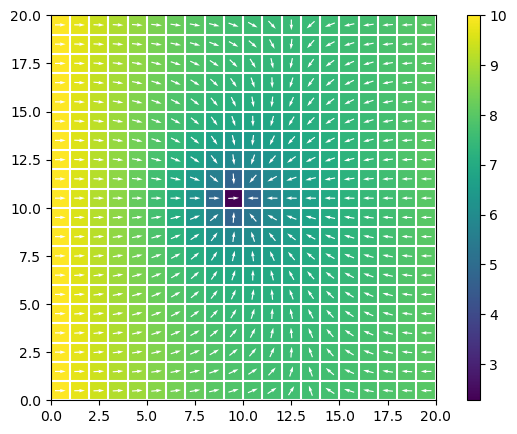

In [37]:
# lets run our model to see what happens
ws3_mod1(sim,gwf)

# Lets try a transient model

In [38]:
# we'll remove the existing tdis package from sim object
sim.remove_package("TDIS")

In [41]:
del tdis # delete the existing tdis object
# now we build a new one
tdis = flopy.mf6.ModflowTdis(sim,
                             time_units='days',
                             start_date_time="2023-12-31T00:00:00",
                             nper=2,
                             perioddata=[(1,1,1),(365.25,52,1)]) # steady-state initial stress period
tdis

package_name = MySim.tdis
filename = MySim.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = MySim

Block options
--------------------
time_units
{internal}
('days')

start_date_time
{internal}
('2023-12-31t00:00:00')


Block dimensions
--------------------
nper
{internal}
(2)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(  1.  ,  1, 1.), (365.25, 52, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', '<i4'), ('tsmult', '<f8')]))



In [42]:
# import a transient version of the same model we used before
from helpers import ws3_mod1_trans

# Changing to a transient stress period data dictionary
So far we have been using a list of lists to create our stress period data and this is fine for boundary conditions that don't vary throughout your simulation. But for this transient simulation we don't want our well active in the steady-state stress period. We want it to start in the second stress period.


In [43]:
# remove the existing wel package from our simulation
gwf.remove_package("WEL")
# Now we build a new one starting with the stress period data DICTIONARY
# We still use the list of lists but now it is stored inside a dictionary 
# with the key representing the stress period number

wel_period_dict = {} # start an empty dictionary
wel1 = [(0,9,9), -10.0,"Mywell"] # adding in a boundary name
wel_period_list = [wel1] # remember that the stress_period data is a list of lists
wel_period_dict[1] = wel_period_list # note the dictioanry key is 1, this is stress period two (zero base)

wel = flopy.mf6.ModflowGwfwel(gwf, boundnames=True, stress_period_data=wel_period_dict) # Note we changed this to the dictionary 
# added the bound and built the object but didn't setup an observation package
# Lets do it now using an initialization method

# setup the observation dictionary the same as before
wel_obs = {
    "wel_flux.csv": [
        ("Well rate", "WEL", "Mywell")]
}
wel.obs.initialize(continuous=wel_obs)
# check the model object to make sure we haven't doubled up on boundaries
gwf.get_package_list()

['DIS', 'CHD_0', 'OBS_0', 'IC', 'NPF', 'OC', 'WEL_0', 'OBS_1']

In [44]:
ws3_mod1_trans(sim,gwf)

building ic package
building npf package
building sto package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_0...
    writing package obs_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs_1...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic 

()

In [45]:
# Lets look at the well file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,'flow.wel'))]

# File generated by Flopy version 3.4.1 on 10/09/2023 at 12:54:47.
BEGIN options
  BOUNDNAMES
  OBS6  FILEIN  flow.wel.obs
END options

BEGIN dimensions
  MAXBOUND  1
END dimensions

BEGIN period  2
  1 10 10     -10.00000000  Mywell
END period  2



# Check the observation files now
Notice that they now have a value for each time step recorded. Not exactly thrilling stuff but lets change our model to vary the pumping and then maybe this will be more interesting to look at.


# What if I want to pump more in summer when there is less surface water and less in winter?
There are different ways to approach this we will do it with a time series because we can vary our stresses at the time step level so no need for lots of stress periods. Previous versions of MODFLOW required that you needed a stress period in order to change any values associated with any transient boundary conditions. The time series needs to extend beyond the activity of the boundary activation that depends on it. For example, if I have a boundary condition active for one year then ideally my time series should extend a day before and a day after to be safe. We will go through the options different options associated with time series files in the workshop or you can read more about how they are configured and what the different variables mean in the MF6io.pdf document. We need to rebuild the well package to change the assigned rates to a time series variable name.


In [46]:
# remove the existing wel package from our simulation
gwf.remove_package("WEL")
# Now we build a new one starting with the stress period data DICTIONARY
# We still use the list of lists but now it is stored inside a dictionary 
# with the key representing the stress period number

wel_period_dict = {} # start an empty dictionary
wel1 = [(0,9,9), "my_rates","Mywell"] # changed the assigned rate to a string that will be used by the time series package adding in a boundary name
wel_period_list = [wel1] # remember that the stress_period data is a list of lists
wel_period_dict[1] = wel_period_list # note the dictioanry key is 1, this is stress period two (zero base)

wel = flopy.mf6.ModflowGwfwel(gwf, 
                              boundnames=True, 
                              stress_period_data=wel_period_dict) # Note we changed this to the dictionary 
# added the bound and built the object but didn't setup an observation package
# Lets do it now using an initialization method

# setup the observation dictionary the same as before
wel_obs = {
    "wel_flux.csv": [
        ("Well rate", "WEL", "Mywell")]
}
wel.obs.initialize(continuous=wel_obs)
# check the model object to make sure we haven't doubled up on boundaries
gwf.get_package_list()

['DIS', 'CHD_0', 'OBS_0', 'IC', 'NPF', 'STO', 'OC', 'WEL_0', 'OBS_1']

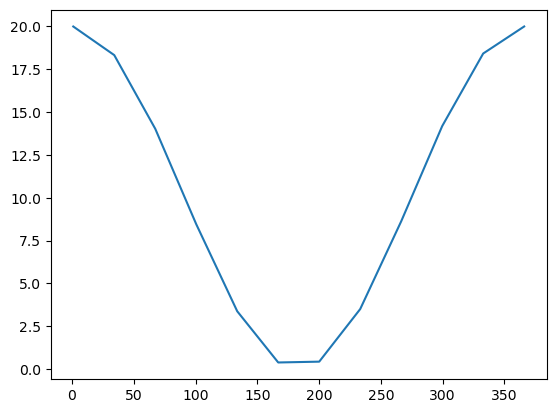

In [47]:
# here I am going to use a sinusoidal function to generate a variable time series

times = np.linspace(1,366,12) # create my sampling periods approximatley monthly over a 366 day period

rates = 10.0 * np.cos(2*np.pi*1/366*times)+10.0 
# 10.0 represents my amplitude, 2*pi means I want a full wave, 
# 1/366 is my frequency so the wave only repeats once every 366 time units
# times is passed in to say "give me the values at each of these sampling times"
# the final 10 is an offset so I don't get the positive to negative swing
plt.plot(times,rates)

In [48]:
# we need to provide the list of times in model runtime, this means that times are days
# 
ts_data = list(zip(times,rates)) 
# initialize first time series
wel.ts.initialize(
    filename="flow.wel.ts", # here I am telling the constructor what filename to use
    timeseries=ts_data, # This will become the time and value columns
    sfacrecord=-1.0, # this is a scaling factor. Why am I using negative 1.0 here?
    time_series_namerecord='my_rates', # this is the name record that the well package has assigned instead of a rate
    interpolation_methodrecord="linear", # there are different interpolation approaches. Read about them in the MF6io.pdf doc
)

In [49]:
# write all the files
wel.write()
wel.obs.write()
wel.ts.write()

INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data


In [50]:
# Lets look at the well file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,'flow.wel'))]

# File generated by Flopy version 3.4.1 on 10/09/2023 at 13:02:23.
BEGIN options
  BOUNDNAMES
  TS6  FILEIN  flow.wel.ts
  OBS6  FILEIN  flow.wel.obs
END options

BEGIN dimensions
  MAXBOUND  1
END dimensions

BEGIN period  2
  1 10 10  my_rates  Mywell
END period  2



In [51]:
# Lets look at the well time-series file
_ = [print(line.rstrip()) for line in open(os.path.join(model_f,'flow.wel.ts'))]

# File generated by Flopy version 3.4.1 on 10/09/2023 at 13:02:23.
BEGIN attributes
  NAMES  my_rates
  METHODS  linear
  SFACS      -1.00000000
END attributes

BEGIN timeseries
       1.00000000      19.99852648
      34.18181818      18.32713906
      67.36363636      14.02597884
     100.54545455       8.45338440
     133.72727273       3.36922272
     166.90909091       0.37911011
     200.09090909       0.42734649
     233.27272727       3.49869844
     266.45454545       8.62321005
     299.63636364      14.18252223
     332.81818182      18.42096260
     366.00000000      20.00000000
END timeseries



In [52]:
# check the model object package list
gwf.get_package_list()

['DIS', 'CHD_0', 'OBS_0', 'IC', 'NPF', 'STO', 'OC', 'WEL_0', 'OBS_1', 'TS_0']

In [54]:
# lets run our model again
ws3_mod1_trans(sim,gwf)

building ic package
building npf package
building sto package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_0...
    writing package obs_0...
    writing package wel_0...
    writing package obs_1...
    writing package ts_0...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                  

()

Hmmm, looks like the model failed because our time series does not extend beyond the end of the simulation. We'll have to try again.

In [55]:
# remove the existing wel package from our simulation
gwf.remove_package("WEL")
# Now we build a new one starting with the stress period data DICTIONARY
# We still use the list of lists but now it is stored inside a dictionary 
# with the key representing the stress period number

wel_period_dict = {} # start an empty dictionary
wel1 = [(0,9,9), "my_rates","Mywell"] # changed the assigned rate to a string that will be used by the time series package adding in a boundary name
wel_period_list = [wel1] # remember that the stress_period data is a list of lists
wel_period_dict[1] = wel_period_list # note the dictioanry key is 1, this is stress period two (zero base)

wel = flopy.mf6.ModflowGwfwel(gwf, 
                              boundnames=True, 
                              stress_period_data=wel_period_dict) # Note we changed this to the dictionary 
# added the bound and built the object but didn't setup an observation package
# Lets do it now using an initialization method

# setup the observation dictionary the same as before
wel_obs = {
    "wel_flux.csv": [
        ("Well rate", "WEL", "Mywell")]
}
wel.obs.initialize(continuous=wel_obs)

times = np.linspace(1,730,24) # create my sampling periods approximatley monthly over a two years.
rates = 10.0 * np.cos(2*np.pi*1/365*times)+10.0
# we need to provide the list of times in model runtime, this means that times are days
# 
ts_data = list(zip(times,rates)) 
# initialize first time series
wel.ts.initialize(
    filename="flow.wel.ts", # here I am telling the constructor what filename to use
    timeseries=ts_data, # This will become the time and value columns
    sfacrecord=-1.0, # this is a scaling factor. Why am I using negative 1.0 here?
    time_series_namerecord='my_rates', # this is the name record that the well package has assigned instead of a rate
    interpolation_methodrecord="linear", # there are different interpolation approaches. Read about them in the MF6io.pdf doc
)

In [56]:
# check the package list
gwf.get_package_list()

['DIS', 'CHD_0', 'OBS_0', 'IC', 'NPF', 'STO', 'OC', 'WEL_0', 'OBS_1', 'TS_0']

In [57]:
# lets run our model again
ws3_mod1_trans(sim,gwf)

building ic package
building npf package
building sto package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_0...
    writing package obs_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs_1...
    writing package ts_0...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Inte

()

# Lets plot up some information from our observation files

In [58]:
# Plotting up your observation flux files
# We will use pandas to load the observation csv files
chd_df = pd.read_csv(os.path.join(model_f,'chd_flux.csv'))
wel_df = pd.read_csv(os.path.join(model_f,'wel_flux.csv'))

# make the time column a datetime index based on model start date
start = pd.to_datetime("2023-12-31T00:00:00") # where did this string come from?
time_series_index = start + pd.to_timedelta(chd_df['time'],unit='days') # this is going to give me a time series index

# Change the index
chd_df.index = time_series_index
wel_df.index = time_series_index

# drop the time column because we don't want to plot this
chd_df.drop(columns='time', inplace=True)
wel_df.drop(columns='time', inplace=True)

# the well has a no-data value for the steady-state stress period (MF6 no-data = 3.0E30)
# We need to convert this to 0.0 or it will cause problems with plotting
wel_df.replace(to_replace=3.0E+30, value=np.NaN, inplace=True)

Text(0, 0.5, 'Extraction Rate $m^{3}d^{-1}$"')

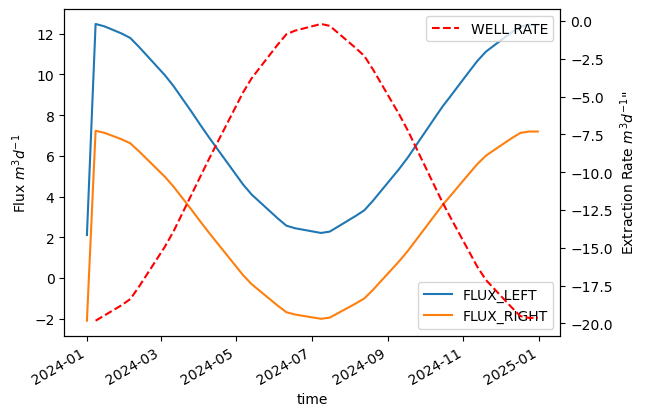

In [59]:
# Easy way to plot with a pandas dataframe if you want to look at your figures
ax = chd_df.plot() # will plot all columns in the dataframe as time series
ax2=ax.twinx() # add a second y axis
wel_df.plot(ax=ax2,linestyle='--',color='red') # change some of the plot styles
ax.set_ylabel("Flux $m^{3}d^{-1}$") # Have you seen the $$ used to format math text before?
ax2.set_ylabel('Extraction Rate $m^{3}d^{-1}$"')

# Multipliers
Most boundary packages feature a few special types of auxiliary variables. One is a multiplier. The other is actually reserved for transport simulations. Here we will demonstrate the use of an auxiliary variable as a multiplier. The nice thing about using the auxiliary variables is that they can be assigned a time series too so instead of a specified value as shown in the example we can also change the entries from numbers to time series names and add those time series to the existing time series file or create completely separate time series files for the different auxiliary variables. The MF6io.pdf document highlights which variables in each package may be assigned a time series.


In [60]:
# remove the existing wel package from our simulation
gwf.remove_package("WEL")
# Now we build a new one starting with the stress period data DICTIONARY
# We still use the list of lists but now it is stored inside a dictionary 
# with the key representing the stress period number

wel_period_dict = {} # start an empty dictionary
wel1 = [(0,9,9), "my_rates",1.5,100.0,"Mywell"] # added mymult=1.5 and concentration=100
wel_period_list = [wel1] # remember that the stress_period data is a list of lists
wel_period_dict[1] = wel_period_list # note the dictioanry key is 1, this is stress period two (zero base)

wel = flopy.mf6.ModflowGwfwel(gwf, 
                              boundnames=True,
                              save_flows=True, # telling it to save flows to the budget file
                              auxiliary=['mymult','concentration'], # here I'm assigning 2 auxiliary variables and naming them
                              auxmultname='mymult', # here I am saying that the first auxiliary variable called mymult is a multiplier
                              stress_period_data=wel_period_dict) # Note we changed this to the dictionary 
# added the bound and built the object but didn't setup an observation package
# Lets do it now using an initialization method

# setup the observation dictionary the same as before
wel_obs = {
    "wel_flux.csv": [
        ("Well rate", "WEL", "Mywell")]
}
wel.obs.initialize(continuous=wel_obs)

times = np.linspace(1,730,24) # create my sampling periods approximatley monthly over a two years.
rates = 10.0 * np.cos(2*np.pi*1/365*times)+10.0
# we need to provide the list of times in model runtime, this means that times are days
# 
ts_data = list(zip(times,rates)) 
# initialize first time series
wel.ts.initialize(
    filename="flow.wel.ts", # here I am telling the constructor what filename to use
    timeseries=ts_data, # This will become the time and value columns
    sfacrecord=-1.0, # this is a scaling factor. Why am I using negative 1.0 here?
    time_series_namerecord='my_rates', # this is the name record that the well package has assigned instead of a rate
    interpolation_methodrecord="linear", # there are different interpolation approaches. Read about them in the MF6io.pdf doc
)

In [61]:
# check the package list
gwf.get_package_list()

['DIS', 'CHD_0', 'OBS_0', 'IC', 'NPF', 'STO', 'OC', 'WEL_0', 'OBS_1', 'TS_0']

In [62]:
# lets run our model again
ws3_mod1_trans(sim,gwf)

building ic package
building npf package
building sto package
building oc package
writing simualtion
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package chd_0...
    writing package obs_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs_1...
    writing package ts_0...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
run simualtion
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Inte

()

# What did the multiplier do?

Text(0, 0.5, 'Extraction Rate $m^{3}d^{-1}$"')

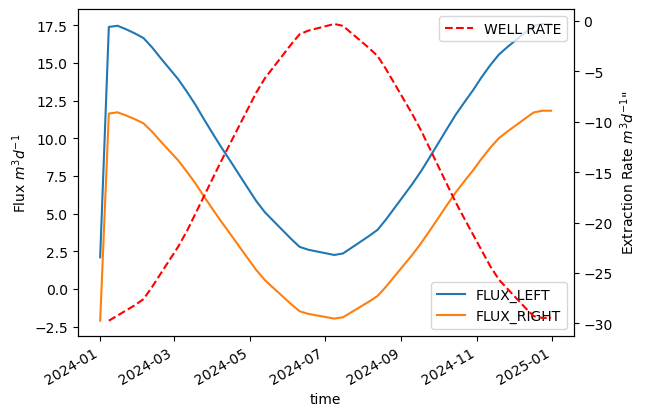

In [63]:
# Plotting up your observation flux files
# We will use pandas to load the observation csv files
chd_df = pd.read_csv(os.path.join(model_f,'chd_flux.csv'))
wel_df = pd.read_csv(os.path.join(model_f,'wel_flux.csv'))

# make the time column a datetime index based on model start date
start = pd.to_datetime("2023-12-31T00:00:00") # where did this string come from?
time_series_index = start + pd.to_timedelta(chd_df['time'],unit='days') # this is going to give me a time series index

# Change the index
chd_df.index = time_series_index
wel_df.index = time_series_index

# drop the time column because we don't want to plot this
chd_df.drop(columns='time', inplace=True)
wel_df.drop(columns='time', inplace=True)

# the well has a no-data value for the steady-state stress period (MF6 no-data = 3.0E30)
# We need to convert this to 0.0 or it will cause problems with plotting
wel_df.replace(to_replace=3.0E+30, value=np.NaN, inplace=True)

# Easy way to plot with a pandas dataframe if you want to look at your figures
ax = chd_df.plot() # will plot all columns in the dataframe as time series
ax2=ax.twinx() # add a second y axis
wel_df.plot(ax=ax2,linestyle='--',color='red') # change some of the plot styles
ax.set_ylabel("Flux $m^{3}d^{-1}$") # Have you seen the $$ used to format math text before?
ax2.set_ylabel('Extraction Rate $m^{3}d^{-1}$"')

# What do these methods cover?
Using the same approach demonstrated in this workshop you should be able to create all of the following boundary conditions:
1. River 
2. General Head Boundary
3. Drain
4. Horizontal Flow Barrier
5. Well
6. Constant head
7. Recharge (list based)
8. Evapotranspiration (list based)

The only difference is the information that needs to be supplied in the stress period data dictionary. For example with the GHB package you would be specifying: 

a model cell, an hydraulic head, a conductance, auxiliary variables, boundary name

There isn't much more to it than that. Selecting your cells can be problematic but we can leverage the intersection objects for that.

# Selcting Cells with grid intersection

In [64]:
# Selecting cells using Flopy intersection methods
from shapely.geometry import (
    LineString,
    Point,
    Polygon,
)
from flopy.utils import GridIntersect

In [65]:
# examples of shapefile geometries obtained from shapley or geopandas
# you can create these shapefiles in a GIS if you have a projected grid
# if there is sufficient time then we will demonstarte this too.
poly = Polygon(shell=[(3, 3),(15.6, 7.7),(14.5, 12.9),(4.7, 10.2)])
line = LineString(coordinates=[(5,4),(19,18)])
point = Point([17.6,5.7])

In [66]:
# create an intersect object
ix = GridIntersect(mg, method="structured")

In [67]:
#perform all the intersections
result1 = ix.intersect(poly)
result2 = ix.intersect(line)
result3 = ix.intersect(point)

In [71]:
# get the cell ids covered by the polygon
result1.cellids

array([(7, 11), (7, 12), (7, 13), (7, 14), (8, 7), (8, 8), (8, 9),
       (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (9, 4), (9, 5),
       (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13),
       (9, 14), (9, 15), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8),
       (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14),
       (10, 15), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9),
       (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15),
       (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8), (12, 9),
       (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15),
       (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), (13, 9),
       (13, 10), (13, 11), (13, 12), (13, 13), (14, 3), (14, 4), (14, 5),
       (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (15, 3),
       (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (16, 3), (16, 4),
       (16, 5)], dtype=object)

In [72]:
# Use them to make a recharge boundary condition
# annual rainfall mean = 1220 mm
# we will start with 1% of annual rainfall
# estimate of 0.5% to 2% of annual
rain_rate = 1220/365/1000 # (m/d)
min_rate = 0.005*rain_rate
max_rate = 0.03*rain_rate
# our preferred value which is central to log of min and max
pv =  10**(np.log10(min_rate)+((np.log10(max_rate)-np.log10(min_rate))/2)) 

rch_list = [[(0,x[0],x[1]),pv,'poly_rch'] for x in result1.cellids] # make the list with the cell ids. 
#Why is l,r,c assigned like this (0,x[0],x[1])?
rch_period = {} # start the dictionary
rch_period[0]=rch_list 
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    boundnames=True,
    save_flows=True,
    stress_period_data=rch_period,
)
# setup the observation dictionary the same as before
rch_obs = {
    "rch_flux.csv": [
        ("Recharge", "RCH", "poly_rch")]
}
rch.obs.initialize(continuous=rch_obs)

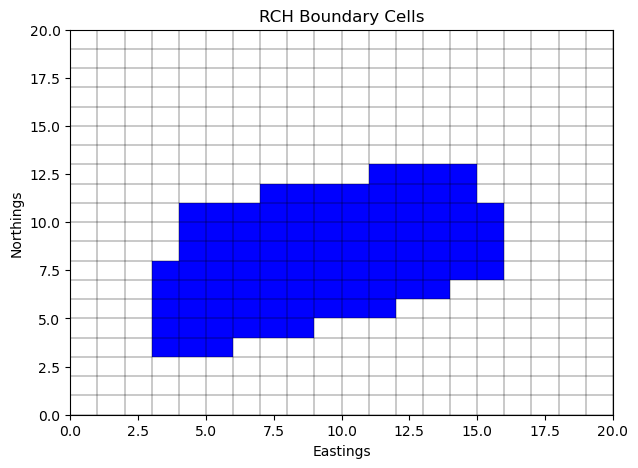

In [73]:
# Lets get a modelgrid object and have a look at the grid
mg = gwf.modelgrid

# create a figure instance to save to our plots folder
fig,ax = plt.subplots(figsize=(7,5)) # we are creating a figure object here so that we can dictate size note there are mutiple ways to do this

# Create the mapview object of the modelgrid and tell it to use the axes we created with our figure
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax) # note by not specifying a layer here it will assume layer 1

# say that you want the Mapview object to plot the grid with linewidth = 0.3 and colour the lines black
pmv.plot_grid(ax=ax, lw=0.3, color="black")

# Now I also want to plot the boundary condition so I specify the package object to plot
pmv.plot_bc(package=rch, color='blue')


ax.set_title('RCH Boundary Cells')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
# lets save it to our plots folder
figname = os.path.join(plots_f,'RCH_bounadry_cells_LR.png') # note use of the plots folder path.
# If you want to change the file format then change the extension from .png to pdf or just do both
fig.savefig(figname,dpi=300)
figname = os.path.join(plots_f,'RCH_bounadry_cells_LR.pdf')
fig.savefig(figname,dpi=300) 

# Depending on time.
If there is time available then we will have a look at a projected grid with inersection and setting up complex transient boundary conditions that would take a long time with GUI's but is relativley quick with a script. If no time is available then we will leave it for later in the series.

# Thats all folks!
Next session will be on configuring array style properties and boundary conditions.